# 모듈 불러오기

In [1]:
import os
os.chdir('..')
if os.getcwd().split("\\")[-1] == "snu-factcheck-analytics":
    from scrap.classes import *
else:
    print('\033[31m\033[43m루트 디렉토리에서 실행해주세요\033[0m')
    print(f'현재 디렉토리는 \033[37m\033[40m{os.getcwd()}\033[0m 입니다.')
    if input("파일이 있는 폴더로 디렉토리를 이동하겠습니까? 'y', 'Y', '' else None : ") in ("y", "Y", ""):
        os.chdir(_dh[0])
    if input("런타임을 재시작하겠습니까? 'y', 'Y', '' else None : ") in ("y", "Y", ""):
        %clear
        %load_ext autoreload
        %autoreload 2

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import yaml
from IPython.display import display
from time import sleep
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from typing import List, Dict, Any, Set, Tuple, Union, Optional


ModuleNotFoundError: No module named 'sklearn'

# 자료 다듬기 


In [3]:

# 발언을 기준으로 스크래핑한 DB를 팩트체크를 기준으로 변경하는 코드입니다.
fc_dict = {}

for key, value in tqdm(speaks_dict.items()):
    sp_info = value.copy() # 발언의 정보를 복사합니다.
    factchecks = sp_info.pop('factchecks') # 발언의 정보에서 팩트체크를 분리합니다.
    for id, fc in factchecks.items():
        fc_info = fc.copy() # 팩트체크의 정보를 복사합니다.
        fc_info.update(sp_info) # 팩트체크의 정보에 발언의 정보를 추가합니다.
        fc_info["speak_id"] = key
        if id in fc_dict:
            print(id)
        fc_dict[id] = fc_info # 팩트체크의 정보를 딕셔너리에 추가합니다.
print(len(fc_dict))


100%|██████████| 3334/3334 [00:00<00:00, 196085.11it/s]

3595


In [4]:
pubs = set(fc['checked_by'] for fc in fc_dict.values())
print(pubs)

{'뉴스톱', '뉴스1', '뉴스포스트', '뉴시스', '한국일보', '아이뉴스24', '문화일보', '조선일보', '국민일보', 'KBS', '한겨레', '이데일리', '오마이뉴스', '동아일보', '전북일보', '중앙일보', '연합뉴스', 'YTN', '시사저널', '동아사이언스', 'MBN', '서울신문', '시사위크', '매일경제', '에너지경제', 'MBC', 'SBS', '중부일보', '한국경제신문', '세계일보', '아시아경제', '노컷뉴스', 'JTBC', '머니투데이', 'TV조선', '채널A', '파이낸셜뉴스'}


In [5]:
# 카테고리를 태그화 합니다.
category = set()
for info in speaks_dict.values():
    category|=info['categories']
category_split = set()
for ct in category:
    category_split |= set(ct.split(', '))
print(category_split)

{'6.13 지방선거', '경제', '정치인(공직자)과 관련된 사실', '새정부', '국회의원 선거', '문화', '국제', '사회', '정치인(공직자)의 발언', '기타', '대통령 선거', '코로나 바이러스', '20대 대통령 선거', '코로나백신', '4.7 재보선', 'IT/과학', '19대 대선', '지방 선거', '정치', '4.15 총선'}


In [6]:
for info in fc_dict.values():
    info['categories'] = ", ".join(info['categories'])
    info['splited_cat'] = set(cat for cat in category_split if cat in info['categories'])

In [7]:
score0, score_nz = {}, {}
for id, fc in fc_dict.items(): (score0, score_nz)[fc['score'] > 0].update({id:fc})
print(len(score0), len(score_nz))
print(fc_dict == score0 | score_nz)

223 3372
True


In [8]:
date_splited = {}
non_date = {}
for id, fc in score_nz.items():
    if fc['date'] == '':
        non_date[id] = fc.copy()
        continue
    date_splited[id] = fc.copy() | {k:v for k, v in zip(('year','month','day'), map(int, fc['date'].split('.')))}
print(len(date_splited), len(non_date))
print(score_nz.keys() == non_date.keys() | date_splited.keys())

3367 5
True


In [9]:
fc_df = pd.DataFrame(date_splited).T
fc_df.head(1)


,checked_by,content,date,score,time,categories,explain,source,speaker,title,speak_id,splited_cat,year,month,day
1,SBS,검증내용 <앵커>대선 국면에 접어들면서 저희 사실은 코너에선 선거 관련 가짜 뉴스와...,2017.03.29,3,09:51,"정치, 19대 대선, 대통령 선거, 정치인(공직자)과 관련된 사실",현재 지지율 1위 문재인 민주당 경선 후보 아들의 취업특혜 논란과 관련된 가짜 뉴스...,{'[사실은] 문재인 아들 취업 특혜 논란…감사 내용 보니': 'http://new...,문재인,현재 지지율 1위 문재인 민주당 경선 후보 아들과 관련한 취업특혜 논란이 있다.,1,"{대통령 선거, 정치인(공직자)과 관련된 사실, 19대 대선, 정치}",2017,3,29


In [ ]:
cat_df

In [10]:
info_df = fc_df[['checked_by', 'year','month','day', 'speaker', 'score']]
info_df

,checked_by,year,month,day,speaker,score
1,SBS,2017,3,29,문재인,3
26,서울신문,2017,4,6,문재인,3
27,한국일보,2017,4,7,문재인,3
2,중앙일보,2017,3,29,이재명,2
3,중앙일보,2017,3,29,안철수,3
...,...,...,...,...,...,...
12899,YTN,2022,1,25,강훈식,1
12912,에너지경제,2022,1,26,기후솔루션,1
12914,연합뉴스,2022,1,26,언론사 자체 문제제기,1
12916,연합뉴스,2022,1,26,주한규,3


In [11]:
cat_list = list(category_split)
cat_list.sort()

cat_df = pd.DataFrame([[cat in info["splited_cat"] for cat in cat_list] for id, info in date_splited.items()], index=fc_df.index, columns=cat_list)
cat_df

,19대 대선,20대 대통령 선거,4.15 총선,4.7 재보선,6.13 지방선거,IT/과학,경제,국제,국회의원 선거,기타,대통령 선거,문화,사회,새정부,정치,정치인(공직자)과 관련된 사실,정치인(공직자)의 발언,지방 선거,코로나 바이러스,코로나백신
1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
26,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
27,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
12912,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
12914,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
12916,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,False,False,False


In [12]:
info_cat_df = pd.DataFrame.merge(info_df,cat_df, left_index=True, right_index=True).fillna(0)
info_cat_df.head(1)

,checked_by,year,month,day,speaker,score,19대 대선,20대 대통령 선거,4.15 총선,4.7 재보선,...,대통령 선거,문화,사회,새정부,정치,정치인(공직자)과 관련된 사실,정치인(공직자)의 발언,지방 선거,코로나 바이러스,코로나백신
1,SBS,2017,3,29,문재인,3,True,False,False,False,...,True,False,False,False,True,True,False,False,False,False


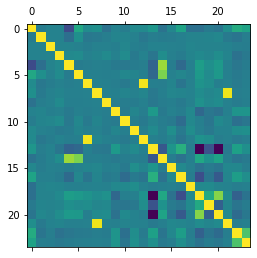

In [ ]:
info_cat_corr = info_cat_df.corr()
plt.matshow(info_cat_corr)
plt.show()
info_cat_corr.to_csv('data/info_cat_corr.csv',encoding="utf-8")

In [31]:
pub_list = sorted(list(pubs))
id_pub = {id:info['checked_by'] for id, info in date_splited.items()}
pub_df = pd.DataFrame([[pubb == pub for pubb in pub_list] for pub in id_pub.values()], index=fc_df.index, columns=pub_list)
pub_df

,JTBC,KBS,MBC,MBN,SBS,TV조선,YTN,국민일보,노컷뉴스,뉴스1,...,이데일리,전북일보,조선일보,중부일보,중앙일보,채널A,파이낸셜뉴스,한겨레,한국경제신문,한국일보
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12912,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12914,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12916,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [36]:
speakers = set(info['speaker'] for info in date_splited.values())
spk_list = sorted(list(speakers))
id_spk = {id:info['speaker'] for id, info in date_splited.items()}
spk_df = pd.DataFrame([[spkb == spk for spkb in spk_list] for spk in id_spk.values()], index=fc_df.index, columns=spk_list)
spk_df

,Airbnb,KT,"KT, LG",LG 유플러스,SNS 가짜뉴스,SNS 등 온라인 매체,SNS 및 정치권,SNS 이용자,"SNS, 온라인 커뮤니티","SNS, 인터넷 커뮤니티",...,화랑지킴이,화학적 거세,환경단체,환경부,환경운동연합,황교안,황교익,황보승희,황영철,후쿠시마현
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12912,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12914,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12916,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [87]:
more_than_6 = spk_df.sum()[spk_df.sum()>6].index
more_than_6

Index(['SNS 등 온라인 매체', 'SNS 이용자', 'SNS, 온라인 커뮤니티', 'SNS, 인터넷 커뮤니티',
       'SNS, 인터넷 커뮤니티, 유튜브', 'SNS, 인터넷 커뮤니티, 유튜브, 언론사 자체 제보', 'SNS와 커뮤니티 이용자',
       '가로세로연구소', '강효상', '관련인 없음', '김문수', '김성태', '김진태', '나경원', '네이버 카페 이용자',
       '네이버뉴스 댓글 이용자', '다수 언론 매체', '다수 언론 매체, 온라인 커뮤니티', '더불어민주당', '문재인',
       '민경욱', '박원순', '발언인 없음', '배현진', '보수 유튜버', '심상정', '심재철', '안철수', '언론 보도',
       '언론 보도 및 온라인 커뮤니티 이용자', '언론보도', '언론보도 및 댓글', '언론사 자체 문제 제기',
       '언론사 자체 문제제기', '오세훈', '온라인 뉴스 댓글 이용자', '온라인 커뮤니티', '온라인 커뮤니티 및 기사 댓글',
       '온라인 커뮤니티 이용자', '온라인 커뮤니티, 언론 보도', '원희룡', '유승민', '유튜버 및 온라인 커뮤니티 이용자',
       '유튜브 이용자', '윤석열', '이낙연', '이명박', '이언주', '이재명', '이준석', '이해찬',
       '인터넷 뉴스 댓글 이용자', '인터넷 루머', '인터넷 이용자', '인터넷 커뮤니티', '인터넷 커뮤니티 및 SNS',
       '인터넷 커뮤니티 이용자', '자유한국당', '전광훈', '전두환', '조국', '주호영', '청와대', '청와대 국민청원',
       '추미애', '트럼프', '페이스북 이용자', '하태경', '한국유치원총연합회', '홍남기', '홍준표', '황교안'],
      dtype='object')

Int64Index([    1,    26,    27,     2,     3,    14,     4,    43,    10,
               11,
            ...
            12852, 12854, 12853, 12868, 12872, 12871, 12875, 12893, 12894,
            12914],
           dtype='int64', length=2219)

In [97]:
mt6_index = spk_df[spk_df[more_than_6].T.any()].index
mt6_index.shape

(2219,)

In [98]:
spk_df.loc[mt6_index, more_than_6]

,SNS 등 온라인 매체,SNS 이용자,"SNS, 온라인 커뮤니티","SNS, 인터넷 커뮤니티","SNS, 인터넷 커뮤니티, 유튜브","SNS, 인터넷 커뮤니티, 유튜브, 언론사 자체 제보",SNS와 커뮤니티 이용자,가로세로연구소,강효상,관련인 없음,...,청와대,청와대 국민청원,추미애,트럼프,페이스북 이용자,하태경,한국유치원총연합회,홍남기,홍준표,황교안
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12871,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12875,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12893,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12894,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [101]:
info_cat_pub_spk = pd.concat([info_df, cat_df, pub_df, spk_df.loc[:, more_than_6]], axis=1).loc[mt6_index]
info_cat_pub_spk.drop(['checked_by', 'speaker'], axis=1, inplace=True)
info_cat_pub_spk.shape
info_cat_pub_spk.to_csv('data/info_cat_pub_spk.csv',encoding="utf-8")


(2219, 133)

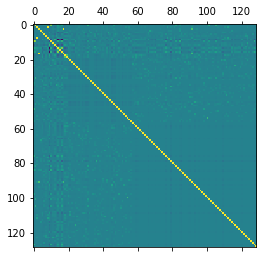

In [104]:
info_cat_pub_spk_corr = info_cat_pub_spk.corr()
plt.matshow(info_cat_pub_spk_corr)
plt.show()
info_cat_pub_spk_corr.to_csv('data/info_cat_pub_spk_corr.csv',encoding="utf-8")

In [121]:
icps_df = info_cat_pub_spk.copy()

target = icps_df.pop('score').astype(int)
data = icps_df
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)

# KNN

In [122]:
from sklearn.neighbors import KNeighborsClassifier

In [123]:
knn = KNeighborsClassifier(n_neighbors=3)


In [124]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [126]:
knn.score(x_valid, y_valid)

0.36711711711711714

In [132]:
def knn_by_n(n:int):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    return knn.score(x_valid, y_valid), n, knn

In [133]:
score_num_model = [knn_by_n(i) for i in range(2, 100)]
max_score, max_num, max_model = max(score_num_model, key=lambda x:x[0])
print(max_num, max_score)

2 0.38963963963963966


(2219,)

In [140]:
target[target == 1].sum()/target.shape[0]

0.36818386660657954

In [134]:
max_model.score(x_train, y_train)

0.6608450704225353

In [141]:
from sklearn.model_selection import KFold

In [159]:
X = data.copy().reset_index(drop = True)
y = target.copy().reset_index(drop = True)

knn = KNeighborsClassifier(n_neighbors = 2)
kfold = KFold(n_splits=5)

cv_score = []
n_iter = 0

## KFold

In [160]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    knn.fit(X_train, y_train)
    n_iter += 1
    score = knn.score(X_test, y_test)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('iteration : {}, score : {}, training data size : {}, test data size : {}'.format(n_iter, score, train_size, test_size))
    print('test set index : {}'.format(test_index.shape[0]))
    cv_score.append(score)

print('average score : {}'.format(np.mean(cv_score)))

iteration : 1, score : 0.31981981981981983, training data size : 1775, test data size : 444
test set index : 444
iteration : 2, score : 0.30180180180180183, training data size : 1775, test data size : 444
test set index : 444
iteration : 3, score : 0.36486486486486486, training data size : 1775, test data size : 444
test set index : 444
iteration : 4, score : 0.3738738738738739, training data size : 1775, test data size : 444
test set index : 444
iteration : 5, score : 0.29345372460496616, training data size : 1776, test data size : 443
test set index : 443
average score : 0.3307628169930653


# Logistic Regression

## Standard Scale

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
X = data.copy().reset_index(drop = True)
y = target.copy().reset_index(drop = True)

sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)

## 


In [164]:
from sklearn.linear_model import LogisticRegression

In [176]:



lr = LogisticRegression(C = 1000, solver = 'liblinear')
kfold = KFold(n_splits=10)

cv_score = []
n_iter = 0

In [178]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    lr.fit(X_train, y_train)
    n_iter += 1
    score = lr.score(X_test, y_test)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('iteration : {}, score : {}, training data size : {}, test data size : {}'.format(n_iter, score, train_size, test_size))
    print('test set index : {}'.format(test_index.shape[0]))
    cv_score.append(score)

print('average score : {}'.format(np.mean(cv_score)))

iteration : 11, score : 0.18468468468468469, training data size : 1997, test data size : 222
test set index : 222
iteration : 12, score : 0.40540540540540543, training data size : 1997, test data size : 222
test set index : 222
iteration : 13, score : 0.36486486486486486, training data size : 1997, test data size : 222
test set index : 222
iteration : 14, score : 0.3918918918918919, training data size : 1997, test data size : 222
test set index : 222
iteration : 15, score : 0.3783783783783784, training data size : 1997, test data size : 222
test set index : 222
iteration : 16, score : 0.3738738738738739, training data size : 1997, test data size : 222
test set index : 222
iteration : 17, score : 0.4594594594594595, training data size : 1997, test data size : 222
test set index : 222
iteration : 18, score : 0.34684684684684686, training data size : 1997, test data size : 222
test set index : 222
iteration : 19, score : 0.3738738738738739, training data size : 1997, test data size : 222


In [179]:
from sklearn.metrics import precision_recall_fscore_support

In [193]:
precision_recall_fscore_support(y_test, lr.predict(X_test))

(array([0.33098592, 0.33333333, 0.        , 0.4       , 0.05      ]),
 array([0.7704918 , 0.11764706, 0.        , 0.34782609, 0.06666667]),
 array([0.46305419, 0.17391304, 0.        , 0.37209302, 0.05714286]),
 array([61, 51, 48, 46, 15], dtype=int64))

In [ ]:
lr = LogisticRegression()


# 발언자 별 사실 점수

In [ ]:
groupby_speaker = fc_df.groupby("speaker")

In [47]:
count_index = fc_df.groupby("speaker").count().sort_values("score", ascending=False).index
fc_df[["speaker", "score"]].groupby("speaker").mean().sort_values("score", ascending=False).reindex(count_index).head(20)

,score
speaker,
발언인 없음,2.892989
언론 보도,1.937888
인터넷 루머,1.902256
문재인,2.660377
홍준표,2.179245
온라인 커뮤니티,1.841584
"SNS, 온라인 커뮤니티",1.742268
관련인 없음,2.379310
안철수,2.319444


In [139]:
fc_df.groupby("speaker").count().sort_values("score", ascending=False).head(20)

,content,date,score,time,explain,source,title,categories,splited_cat
speaker,,,,,,,,,
발언인 없음,302,302,302,302,302,302,302,302,302
언론 보도,170,170,170,170,170,170,170,170,170
인터넷 루머,138,138,138,138,138,138,138,138,138
홍준표,111,111,111,111,111,111,111,111,111
문재인,111,111,111,111,111,111,111,111,111
온라인 커뮤니티,103,103,103,103,103,103,103,103,103
"SNS, 온라인 커뮤니티",102,102,102,102,102,102,102,102,102
관련인 없음,95,95,95,95,95,95,95,95,95
안철수,74,74,74,74,74,74,74,74,74


In [18]:
raw_speaker_score = fc_df[["speaker", "score"]].groupby("speaker")
ss_df = raw_speaker_score.count().sort_values("score", ascending=False)
ss_df["mean"] = raw_speaker_score.mean()
ss_df["std"] = raw_speaker_score.std()
ss_df.head(20)

,score,mean,std
speaker,,,
발언인 없음,302,2.596026,1.512644
언론 보도,170,1.823529,1.121880
인터넷 루머,138,1.833333,1.211763
홍준표,111,2.081081,1.258680
문재인,111,2.522523,1.249341
온라인 커뮤니티,103,1.786408,1.209849
"SNS, 온라인 커뮤니티",102,1.656863,1.130102
관련인 없음,95,2.210526,1.577061
안철수,74,2.202703,1.303102


In [161]:
ss_df.to_csv("scrap/speaker_score.csv",encoding="utf-8")

In [19]:
ss_df

,score,mean,std
speaker,,,
발언인 없음,302,2.596026,1.512644
언론 보도,170,1.823529,1.121880
인터넷 루머,138,1.833333,1.211763
홍준표,111,2.081081,1.258680
문재인,111,2.522523,1.249341
...,...,...,...
오션클린업,1,0.000000,NaN
네이버 부동산 커뮤니티,1,2.000000,NaN
오병윤·오현주,1,3.000000,NaN


In [3]:
content_words = pd.concat([pd.read_csv("data/content_word%d.csv"%i) for i in range(3)],axis=1)
content_words.shape

(3549, 29482)